# **Sentence sequence labeling approach for Rhetorical Roles (RR) classification task**

**Description of our approach:** The primary idea for model development that has been proposed in this work, is a sentence-sequence classification based idea, where a local-context based dataset is  built for model training. This dataset is built with a sentence window size of 5, where we hoped to train a sentence-sequence classification model that can learn from it's local context. The reason for restricting the window size to 5 sentences is due to the resource constraints as well as the extremely lengthy nature of legal documents.

**During Prediction:** During inference we consider two different ways of recovering the sentence level labels: considering the middle sentence in an input sequence as the sentence of interest for recording it's label and considering the last sentence as the sentence of interest. These two approaches are called as the "$M_{SS-Mid}$" and "$M_{SS-End}$" respectively.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re
import csv
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam


In [ ]:
!pip install transformers

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 12.3 MB/s eta 0:00:00
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
bert_model = AutoModel.from_pretrained("law-ai/InLegalBERT",output_hidden_states=True)
bert_model = bert_model.to('cuda')

def numpyarray(sent):
  granola_ids = tokenizer.encode(sent, max_length=100)
  granola_ids = torch.LongTensor(granola_ids)
  granola_ids = granola_ids.to(device)
  # print(granola_ids.shape)
  bert_model.eval()
  granola_ids = granola_ids.unsqueeze(0)
  # print(granola_ids.shape)
  with torch.no_grad():
    out = bert_model(input_ids=granola_ids)
    # print(out[0].shape)
  hidden_states = out[2]
  sentence_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()
  # print(sentence_embedding.shape)
  np_tensor = sentence_embedding.cpu().numpy()
  return np_tensor


Some weights of the model checkpoint at law-ai/InLegalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


*The below code creates the sentence sequential training dataset in which we consider four previous sentences.*

In [ ]:
# import numpy as np #considers 4 previous sentences, in total 5 sentences
# def dataset_creation(doc,labels):
#   s1 = np.zeros(768)
#   # print(type(s1))
#   s2=np.zeros(768)
#   s3=np.zeros(768)
#   s4=np.zeros(768)
#   fl=[]
#   fl_l=[]
#   dc=[]
#   label_list=[]
#   dc.append(s1)
#   label_list.append('pad')
#   dc.append(s2)
#   label_list.append('pad')
#   dc.append(s3)
#   label_list.append('pad')
#   dc.append(s4)
#   label_list.append('pad')
#   dc.append(numpyarray(doc[0]))
#   label_list.append(labels[0])
#   fl.append(np.stack(dc))
#   fl_l.append(label_list)
#   dc=[]
#   label_list=[]
#   dc.append(s2)
#   label_list.append('pad')
#   dc.append(s3)
#   label_list.append('pad')
#   dc.append(s4)
#   label_list.append('pad')
#   dc.append(numpyarray(doc[0]))
#   label_list.append(labels[0])
#   dc.append(numpyarray(doc[1]))
#   label_list.append(labels[1])
#   fl.append(np.stack(dc))
#   fl_l.append(label_list)
#   dc=[]
#   label_list=[]
#   dc.append(s3)
#   label_list.append('pad')
#   dc.append(s4)
#   label_list.append('pad')
#   dc.append(numpyarray(doc[0]))
#   label_list.append(labels[0])
#   dc.append(numpyarray(doc[1]))
#   label_list.append(labels[1])
#   dc.append(numpyarray(doc[2]))
#   label_list.append(labels[2])
#   fl.append(np.stack(dc))
#   fl_l.append(label_list)
#   dc=[]
#   label_list=[]
#   dc.append(s4)
#   label_list.append('pad')
#   dc.append(numpyarray(doc[0]))
#   label_list.append(labels[0])
#   dc.append(numpyarray(doc[1]))
#   label_list.append(labels[1])
#   dc.append(numpyarray(doc[2]))
#   label_list.append(labels[2])
#   dc.append(numpyarray(doc[3]))
#   label_list.append(labels[3])
#   fl.append(np.stack(dc))
#   fl_l.append(label_list)

#   for i in range(4,len(doc)):
#     dc=[]
#     label_list=[]
#     dc.append(numpyarray(doc[i-4]))
#     label_list.append(labels[i-4])
#     dc.append(numpyarray(doc[i-3]))
#     label_list.append(labels[i-3])
#     dc.append(numpyarray(doc[i-2]))
#     label_list.append(labels[i-2])
#     dc.append(numpyarray(doc[i-1]))
#     label_list.append(labels[i-1])
#     dc.append(numpyarray(doc[i]))
#     label_list.append(labels[i])
#     fl.append(np.stack(dc))
#     fl_l.append(label_list)
#   # for i in range(len(fl)):
#   #   print(fl[i].shape)
#   fl=np.stack(fl)
#   return fl, fl_l

In [ ]:
# samplesX=[]
# samplesY=[]
# for i in range(len(CleanedText)):
#   x,y=new_dataset_creation(CleanedText[i],AllLabels[i])
#   samplesX.append(x)
#   samplesY+=y
#   print(i)
# samplesX=np.vstack(samplesX)
# print(len(samplesY))
# print(samplesX.shape)

In [ ]:
f = open("/content/drive/My Drive/Colab Notebooks/LegalEval/RR_dev.json")

data = json.load(f)
print("Total validation samples provided by the organizers: ", len(data))

AllText=[]
for i in range(len(data)):
    TempText=[]
    if len(data[i]['annotations'][0]['result'])!=0:

        for j in range(len(data[i]['annotations'][0]['result'])):
            TempText.append(data[i]['annotations'][0]['result'][j]['value']['text'])
        AllText.append(TempText)


CleanedText=[]
for i in range(len(AllText)):
    TempCleanedText=[]
    for j in range(len(AllText[i])):
        AllText[i][j]=AllText[i][j].replace("\n"," ")
        AllText[i][j]=re.sub('\s+',' ',AllText[i][j])
        AllText[i][j]=AllText[i][j].lower()
        TempCleanedText.append(AllText[i][j])
    CleanedText.append(TempCleanedText)  
print("After cleaning, total number of samples in validation data (documentwise): ", len(CleanedText))

AllLabels=[]
for i in range(len(data)):
    TempLabels=[]
    if len(data[i]['annotations'][0]['result'])!=0:
        for j in range(len(data[i]['annotations'][0]['result'])):
            TempLabels.append(data[i]['annotations'][0]['result'][j]['value']['labels'][0])
        AllLabels.append(TempLabels)
    
for i in range(len(AllLabels)):
    for j in range(len(AllLabels[i])):
        AllLabels[i][j]=AllLabels[i][j].lower()    
print("After cleaning, total number of labels in validation data (documentwise): ", len(AllLabels)) 

Total validation samples provided by the organizers:  30
After cleaning, total number of samples in validation data (documentwise):  30
After cleaning, total number of labels in validation data (documentwise):  30


*The sequential dataset that we have created is utilized for training.*

In [ ]:
npy_samplesX=np.load('/content/drive/My Drive/Colab Notebooks/LegalEval/samplesX_5_sent.npy')
print(npy_samplesX.shape)
npy_ValSamplesX=np.load('/content/drive/My Drive/Colab Notebooks/LegalEval/ValSamplesX_5_sent.npy')
print(npy_ValSamplesX.shape)

(28986, 5, 768)
(2879, 5, 768)


In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/LegalEval/samplesY_5_sent.csv',header=None)
df_samplesY=df.values.tolist()
print(len(df_samplesY))
print(df_samplesY[0])
print(df_samplesY[5])

28986
['pad', 'pad', 'pad', 'pad', 'preamble']
['preamble', 'preamble', 'preamble', 'none', 'fac']


In [ ]:
df_val=pd.read_csv('/content/drive/My Drive/Colab Notebooks/LegalEval/ValSamplesY_5_sent.csv',header=None)
df_val.describe()
df_val_samplesY=df_val.values.tolist()
print(len(df_val_samplesY))
print(df_val_samplesY[0])
print(df_val_samplesY[5])

2879
['pad', 'pad', 'pad', 'pad', 'preamble']
['preamble', 'preamble', 'preamble', 'preamble', 'preamble']


*Weconsidered one more label 'pad' for those sentences that we have considered for creating sequential dataset.*

In [ ]:
num2text_label_dict={0:'analysis',1: 'arg_petitioner',2:'arg_respondent',3:'fac',4: 'issue',
            5:'none',6:'pre_not_relied',7: 'pre_relied',8:'preamble',9:'ratio',10:'rlc',11: 'rpc',12:'sta',13:'pad'}

text2num_label_dict={v:k for k,v in num2text_label_dict.items()}

encoded_samplesY=[]
for i in range(len(df_samplesY)):
  temp=[]
  for j in range(len(df_samplesY[i])):
    temp.append(text2num_label_dict[df_samplesY[i][j]])
  encoded_samplesY.append(temp)
encoded_samplesY=np.array(encoded_samplesY)
print(encoded_samplesY.shape) 
print(encoded_samplesY[0])

(28986, 5)
[13 13 13 13  8]


In [ ]:
encoded_val_samplesY=[]
for i in range(len(df_val_samplesY)):
  temp=[]
  for j in range(len(df_val_samplesY[i])):
    temp.append(text2num_label_dict[df_val_samplesY[i][j]])
  encoded_val_samplesY.append(temp)
encoded_val_samplesY=np.array(encoded_val_samplesY)
print(encoded_val_samplesY.shape) 
print(encoded_val_samplesY[0])

(2879, 5)
[13 13 13 13  8]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
from tensorflow.keras import regularizers 
 
model = Sequential()
model.add(InputLayer(input_shape=(5,768, )))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(14)))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(0.001),metrics=['accuracy'])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 5, 256)           918528    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 5, 256)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 5, 256)           394240    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 5, 256)            0         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 14)            3598      
 tributed)                                                       
                                                      

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history=model.fit(npy_samplesX, encoded_samplesY, validation_data=(npy_ValSamplesX,encoded_val_samplesY),epochs =500,callbacks=[es], batch_size= 16, shuffle=True)

Epoch 1/500
1812/1812 [==============================] - 40s 15ms/step - loss: 0.9447 - accuracy: 0.6846 - val_loss: 0.9745 - val_accuracy: 0.6950
Epoch 2/500
1812/1812 [==============================] - 17s 9ms/step - loss: 0.6263 - accuracy: 0.7820 - val_loss: 0.8738 - val_accuracy: 0.7499
Epoch 3/500
1812/1812 [==============================] - 16s 9ms/step - loss: 0.4589 - accuracy: 0.8382 - val_loss: 0.9788 - val_accuracy: 0.7489
Epoch 4/500
1812/1812 [==============================] - 16s 9ms/step - loss: 0.3445 - accuracy: 0.8774 - val_loss: 0.9838 - val_accuracy: 0.7470
Epoch 5/500
1812/1812 [==============================] - 16s 9ms/step - loss: 0.2558 - accuracy: 0.9091 - val_loss: 1.0863 - val_accuracy: 0.7464
Epoch 6/500
1812/1812 [==============================] - 19s 10ms/step - loss: 0.2017 - accuracy: 0.9282 - val_loss: 1.2671 - val_accuracy: 0.7255
Epoch 7/500
1812/1812 [==============================] - 16s 9ms/step - loss: 0.1670 - accuracy: 0.9403 - val_loss: 1.3222

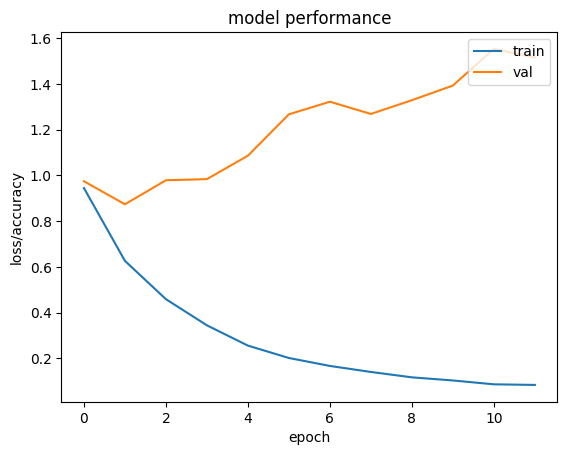

In [ ]:
from matplotlib import pyplot as plt
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model performance')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# model.save('/content/drive/My Drive/Colab Notebooks/LegalEval/ModelIndLegal_5Sent.h5')

In [ ]:
# import keras
# model=keras.models.load_model('/content/drive/My Drive/Colab Notebooks/LegalEval/ModelIndLegal_5Sent.h5')

*During Prediction, we considered two previous and 2 next sentences as a context. The sentences present at index 2 is the final prediction. In our paper, we call this approach as $M_{SS-Mid}$.* 

In [ ]:
#prev two sentences and next two sentences
import numpy as np
def test1_dataset_creation(doc):
  s1 = np.zeros(768)
  # print(type(s1))
  s2=np.zeros(768)
  s3=np.zeros(768)
  s4=np.zeros(768)

  fl=[]

  dc=[]
  dc.append(s1)
  dc.append(s2)
  dc.append(numpyarray(doc[0]))
  dc.append(numpyarray(doc[1]))
  dc.append(numpyarray(doc[2]))

  
  fl.append(np.stack(dc))
  
  dc=[]
  
  dc.append(s2)
  dc.append(numpyarray(doc[0]))
  
  dc.append(numpyarray(doc[1]))
  dc.append(numpyarray(doc[2]))
  dc.append(numpyarray(doc[3]))
  fl.append(np.stack(dc))
  
  for i in range(2,len(doc)-2):
    dc=[]
    
    dc.append(numpyarray(doc[i-2]))
    dc.append(numpyarray(doc[i-1]))
    dc.append(numpyarray(doc[i]))
    dc.append(numpyarray(doc[i+1]))
    dc.append(numpyarray(doc[i+2]))
    fl.append(np.stack(dc))
    
  # for i in range(len(fl)):
  #   print(fl[i].shape)
  dc=[]
  dc.append(numpyarray(doc[-4]))
  dc.append(numpyarray(doc[-3]))
  dc.append(numpyarray(doc[-2]))
  dc.append(numpyarray(doc[-1]))
  dc.append(s3)
  fl.append(np.stack(dc))
  
  dc=[]
  dc.append(numpyarray(doc[-3]))
  dc.append(numpyarray(doc[-2]))
  dc.append(numpyarray(doc[-1]))
  dc.append(s3)
  dc.append(s4)
  fl.append(np.stack(dc))
  
  fl=np.stack(fl)
  return fl

In [ ]:
def predict(doc):
  compPred=[]
  x=test1_dataset_creation(doc)
  # print(x.shape)
  y_prob=model.predict(x)
  # print(np.array(y_prob).shape)
  # print(y_prob)
  flat_pred=np.argmax(y_prob,axis=2)
  flat_pred_list= flat_pred.tolist()
  final_preds=[]
  for i in range(len(flat_pred_list)):
    # final_preds.append(flat_pred_list[i][-1])
    final_preds.append(flat_pred_list[i][2])
  return final_preds
Preds=[]
for i in range(len(CleanedText)):
  Preds.append(predict(CleanedText[i]))
  print(i)

print(Preds)
print(len(Preds[1]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


3/3 [==============================] - 1s 6ms/step
0
5/5 [==============================] - 1s 4ms/step
1
5/5 [==============================] - 0s 6ms/step
2
2/2 [==============================] - 0s 6ms/step
3
3/3 [==============================] - 0s 5ms/step
4
2/2 [==============================] - 0s 8ms/step
5
3/3 [==============================] - 0s 7ms/step
6
4/4 [==============================] - 0s 5ms/step
7
7/7 [==============================] - 0s 4ms/step
8
5/5 [==============================] - 0s 6ms/step
9
3/3 [==============================] - 0s 6ms/step
10
4/4 [==============================] - 0s 5ms/step
11
7/7 [==============================] - 0s 4ms/step
12
5/5 [==============================] - 0s 5ms/step
13
2/2 [==============================] - 0s 9ms/step
14
2/2 [==============================] - 0s 7ms/step
15
4/4 [==============================] - 0s 4ms/step
16
4/4 [==============================] - 0s 5ms/step
17
2/2 [==============================] -

In [ ]:
num2text_label_dict={0:'analysis',1: 'arg_petitioner',2:'arg_respondent',3:'fac',4: 'issue',
            5:'none',6:'pre_not_relied',7: 'pre_relied',8:'preamble',9:'ratio',10:'rlc',11: 'rpc',12:'sta',13:'pad'}

text2num_label_dict={v:k for k,v in num2text_label_dict.items()}
PredValLabels=[]
for i in range(len(Preds)):
  temp=[]
  for j in range(len(Preds[i])):
    temp.append(num2text_label_dict[Preds[i][j]])
  PredValLabels.append(temp)

In [ ]:
ActSentwiseLabels=[]
for i in range(len(AllLabels)):
  for j in range(len(AllLabels[i])):
    ActSentwiseLabels.append(AllLabels[i][j])

In [ ]:
PredSentwiseLabels=[]
for i in range(len(PredValLabels)):
  for j in range(len(PredValLabels[i])):
    PredSentwiseLabels.append(PredValLabels[i][j])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(ActSentwiseLabels, PredSentwiseLabels, average='weighted')

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7562048304624073, 0.7568600208405697, 0.7356480780288189, None)

In [ ]:
label_list=['analysis','arg_petitioner','arg_respondent','fac', 'issue','none','pre_not_relied','pre_relied','preamble','ratio','rlc','rpc','sta']
precision_recall_fscore_support(ActSentwiseLabels, PredSentwiseLabels, average=None, labels=label_list)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.6776365 , 0.58333333, 0.5       , 0.79017013, 0.87179487,
        0.96932515, 0.        , 0.63095238, 0.90781563, 0.56862745,
        0.70833333, 0.85869565, 0.48387097]),
 array([0.92073171, 0.2       , 0.07894737, 0.72068966, 0.68      ,
        0.83157895, 0.        , 0.37323944, 0.89173228, 0.41428571,
        0.14655172, 0.86813187, 0.53571429]),
 array([0.78069798, 0.29787234, 0.13636364, 0.75383228, 0.76404494,
        0.89518414, 0.        , 0.46902655, 0.89970209, 0.47933884,
        0.24285714, 0.86338798, 0.50847458]),
 array([984,  70,  38, 580,  50, 190,  12, 142, 508,  70, 116,  91,  28]))

In [ ]:
num2text_label_dict={0:'analysis',1: 'arg_petitioner',2:'arg_respondent',3:'fac',4: 'issue',
            5:'none',6:'pre_not_relied',7: 'pre_relied',8:'preamble',9:'ratio',10:'rlc',11: 'rpc',12:'sta',13:'pad'}

text2num_label_dict={v:k for k,v in num2text_label_dict.items()}
ActualValLabels=[]
for i in range(len(AllLabels)):
  temp=[]
  for j in range(len(AllLabels[i])):
    temp.append(text2num_label_dict[AllLabels[i][j]])
  ActualValLabels.append(temp)

*This is the second way of predcting labels in which we consider the last sentence as the sentence of interest. We call this approach as $M_{SS-End}$ in our paper.*

In [ ]:
import numpy as np
def test_dataset_creation(doc):
  s1 = np.zeros(768)
  # print(type(s1))
  s2=np.zeros(768)
  s3=np.zeros(768)
  s4=np.zeros(768)
  fl=[]
  
  dc=[]
  
  dc.append(s1)
  
  dc.append(s2)
  
  dc.append(s3)
  
  dc.append(s4)
  
  dc.append(numpyarray(doc[0]))
  
  fl.append(np.stack(dc))
  
  dc=[]
  
  dc.append(s2)
  
  dc.append(s3)
  
  dc.append(s4)
  
  dc.append(numpyarray(doc[0]))
  
  dc.append(numpyarray(doc[1]))
  
  fl.append(np.stack(dc))
  
  dc=[]
  
  dc.append(s3)
  
  dc.append(s4)
  
  dc.append(numpyarray(doc[0]))
  
  dc.append(numpyarray(doc[1]))
  
  dc.append(numpyarray(doc[2]))
  
  fl.append(np.stack(dc))
  
  dc=[]
  
  dc.append(s4)
  
  dc.append(numpyarray(doc[0]))
  
  dc.append(numpyarray(doc[1]))
  
  dc.append(numpyarray(doc[2]))
  
  dc.append(numpyarray(doc[3]))
  
  fl.append(np.stack(dc))
  

  for i in range(4,len(doc)):
    dc=[]
    
    dc.append(numpyarray(doc[i-4]))
    
    dc.append(numpyarray(doc[i-3]))
    
    dc.append(numpyarray(doc[i-2]))
    
    dc.append(numpyarray(doc[i-1]))
    
    dc.append(numpyarray(doc[i]))
    
    fl.append(np.stack(dc))
    
  # for i in range(len(fl)):
  #   print(fl[i].shape)
  fl=np.stack(fl)
  return fl

In [ ]:
def predict(doc):
  compPred=[]
  x=test_dataset_creation(doc)
  y_prob=model.predict(x)
  flat_pred=np.argmax(y_prob,axis=2)
  flat_pred_list= flat_pred.tolist()
  final_preds=[]
  for i in range(len(flat_pred_list)):
    final_preds.append(flat_pred_list[i][-1])
  return final_preds
  
Preds=[]
for i in range(len(CleanedText)):
  Preds.append(predict(CleanedText[i]))
  print(i)

print(Preds)
print(len(Preds[1]))

3/3 [==============================] - 0s 8ms/step
0
5/5 [==============================] - 0s 4ms/step
1
5/5 [==============================] - 0s 5ms/step
2
2/2 [==============================] - 0s 7ms/step
3
3/3 [==============================] - 0s 8ms/step
4
2/2 [==============================] - 0s 14ms/step
5
3/3 [==============================] - 0s 9ms/step
6
4/4 [==============================] - 0s 5ms/step
7
7/7 [==============================] - 0s 4ms/step
8
5/5 [==============================] - 0s 6ms/step
9
3/3 [==============================] - 0s 6ms/step
10
4/4 [==============================] - 0s 5ms/step
11
7/7 [==============================] - 0s 4ms/step
12
5/5 [==============================] - 0s 4ms/step
13
2/2 [==============================] - 0s 7ms/step
14
2/2 [==============================] - 0s 7ms/step
15
4/4 [==============================] - 0s 5ms/step
16
4/4 [==============================] - 0s 5ms/step
17
2/2 [==============================] 

In [ ]:
num2text_label_dict={0:'analysis',1: 'arg_petitioner',2:'arg_respondent',3:'fac',4: 'issue',
            5:'none',6:'pre_not_relied',7: 'pre_relied',8:'preamble',9:'ratio',10:'rlc',11: 'rpc',12:'sta',13:'pad'}

text2num_label_dict={v:k for k,v in num2text_label_dict.items()}
PredValLabels=[]
for i in range(len(Preds)):
  temp=[]
  for j in range(len(Preds[i])):
    temp.append(num2text_label_dict[Preds[i][j]])
  PredValLabels.append(temp)

PredSentwiseLabels=[]
for i in range(len(PredValLabels)):
  for j in range(len(PredValLabels[i])):
    PredSentwiseLabels.append(PredValLabels[i][j])

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(ActSentwiseLabels, PredSentwiseLabels, average='weighted')


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7318456131135416, 0.741229593608892, 0.7139155007924255, None)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
num2text_label_dict={0:'analysis',1: 'arg_petitioner',2:'arg_respondent',3:'fac',4: 'issue',
            5:'none',6:'pre_not_relied',7: 'pre_relied',8:'preamble',9:'ratio',10:'rlc',11: 'rpc',12:'sta',13:'pad'}

text2num_label_dict={v:k for k,v in num2text_label_dict.items()}
PredValLabels=[]
for i in range(len(Preds)):
  temp=[]
  for j in range(len(Preds[i])):
    temp.append(num2text_label_dict[Preds[i][j]])
  PredValLabels.append(temp)

PredSentwiseLabels=[]
for i in range(len(PredValLabels)):
  for j in range(len(PredValLabels[i])):
    PredSentwiseLabels.append(PredValLabels[i][j])

precision_recall_fscore_support(ActSentwiseLabels, PredSentwiseLabels, average='micro')

label_list=['analysis','arg_petitioner','arg_respondent','fac', 'issue','none','pre_not_relied','pre_relied','preamble','ratio','rlc','rpc','sta']
precision_recall_fscore_support(ActSentwiseLabels, PredSentwiseLabels, average=None, labels=label_list)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.65223771, 0.53846154, 0.5       , 0.79887218, 0.8       ,
        0.92941176, 0.        , 0.6       , 0.88781431, 0.4       ,
        0.6       , 0.85882353, 0.59259259]),
 array([0.90345528, 0.2       , 0.05263158, 0.73275862, 0.64      ,
        0.83157895, 0.        , 0.31690141, 0.90354331, 0.08571429,
        0.12931034, 0.8021978 , 0.57142857]),
 array([0.75756285, 0.29166667, 0.0952381 , 0.76438849, 0.71111111,
        0.87777778, 0.        , 0.41474654, 0.89560976, 0.14117647,
        0.21276596, 0.82954545, 0.58181818]),
 array([984,  70,  38, 580,  50, 190,  12, 142, 508,  70, 116,  91,  28]))

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

PScore=[]
for i in range(len(ActualValLabels)):
  PScore.append(precision_score(ActualValLabels[i],Preds[i], average='micro'))
# print(F1Score)
print(sum(PScore)/len(ActualValLabels))

RScore=[]
for i in range(len(ActualValLabels)):
  RScore.append(recall_score(ActualValLabels[i],Preds[i], average='micro'))
# print(F1Score)
print(sum(RScore)/len(ActualValLabels))

F1Score=[]
for i in range(len(ActualValLabels)):
  F1Score.append(f1_score(ActualValLabels[i],Preds[i], average='micro'))
# print(F1Score)
print(sum(F1Score)/len(ActualValLabels))

0.733370285385263
0.733370285385263
0.733370285385263
